In [1]:
!pip install yfinance 
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd

## 抓取股票資料

In [3]:
import yfinance as yf


SYMBOL = "2330.TW"
HISTORY = "10y"

all_day_k = yf.Ticker(SYMBOL).history(period = HISTORY, interval = "1d")

In [4]:
# Remove unnecessary columns
all_day_k = all_day_k.drop(columns=["Dividends", "Stock Splits"])

# Remove the last row cuz it is not a complete day
all_day_k = all_day_k[:-1]

In [5]:
PAST_WIN_LEN = 100
CLASSES =["Bull", "Bear"]
LABEL_BULL = CLASSES.index("Bull")
LABEL_BEAR = CLASSES.index("Bear")

x,y = [], []
for today_i in range (len(all_day_k)):
    day_k_past = all_day_k.iloc[:today_i + 1]
    day_k_forward = all_day_k[today_i + 1:]
    if len(day_k_past) < PAST_WIN_LEN or len(day_k_forward) < 1:
        continue
    day_k_past_win = day_k_past[-PAST_WIN_LEN:]
    day_k_forward_win = day_k_forward[:1]

    # Get the label
    today_price = day_k_past_win.iloc[-1]["Close"]
    tommorow_price = day_k_forward_win.iloc[0]["Close"]
    label = LABEL_BULL if today_price < tommorow_price else LABEL_BEAR

    # Store the data
    x.append(day_k_past_win.values)
    y.append(label)


x, y = np.array(x), np.array(y)

In [6]:
# 訓練集, 驗證集, 測試集的比例
TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT = 0.7, 0.2, 0.1

test_split_index = round(len(x) * (1 - TEST_SPLIT))  # 90%
x_other, x_test = np.split(x, [test_split_index])
y_other, y_test = np.split(y, [test_split_index])

train_val_ratio = TRAIN_SPLIT / (TRAIN_SPLIT + VAL_SPLIT)  # 0.7 / (0.7+0.2) = 0.7777
train_split_index = round(len(x_other) * train_val_ratio)

indexes = np.arange(len(x_other))
np.random.shuffle(indexes)

train_indexes, val_indexes = np.split(indexes, [train_split_index])

x_train, x_val = x_other[train_indexes], x_other[val_indexes]
y_train, y_val = y_other[train_indexes], y_other[val_indexes]

In [7]:
# 3項數據資料的標籤分布
label_distribution = pd.DataFrame([{"Dataset": "train", "Bull": np.count_nonzero(y_train == LABEL_BULL), "Bear": np.count_nonzero(y_train == LABEL_BEAR)}, {"Dataset": "val", "Bull": np.count_nonzero(y_val == LABEL_BULL), "Bear": (y_val == LABEL_BEAR)}, {"Dataset": "test", "Bull": np.count_nonzero(y_test == LABEL_BULL), "Bear": np.count_nonzero(y_test == LABEL_BEAR)}])

In [8]:
# 平衡測試集的牛市和熊市標籤
x_test_bull = x_test[y_test == LABEL_BULL]
x_test_bear = x_test[y_test == LABEL_BEAR]

min_n_labels = min(len(x_test_bull), len(x_test_bear))

x_test_bull = x_test_bull[np.random.choice(len(x_test_bull), min_n_labels, replace=False), :]
x_test_bear = x_test_bear[np.random.choice(len(x_test_bear), min_n_labels, replace=False), :]
x_test = np.vstack([x_test_bull, x_test_bear])

y_test = np.array([LABEL_BULL] * min_n_labels + [LABEL_BEAR] * min_n_labels)

# Test dataset label distribution
pd.DataFrame([{"Dataset": "test", "Bull": np.count_nonzero(y_test == LABEL_BULL), "Bear": np.count_nonzero(y_test == LABEL_BEAR)}])

,Dataset,Bull,Bear
0,test,111,111


## 儲存資料集

In [12]:
np.savez("datasets.npz", x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test)

In [9]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

# Build MLP model
n_time_steps = x_train.shape[1]
n_features = x_train.shape[2]

input_layer = Input(shape=(n_time_steps, n_features))
x = Flatten()(input_layer)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       128,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,562 (760.01 KB)

 Trainable params: 194,562 (760.01 KB)

 Non-trainable params: 0 (0.00 B)

## 訓練模型

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)
callbacks = [model_checkpoint, early_stopping]

train_history = model.fit(x_train, to_categorical(y_train), validation_data=(x_val, to_categorical(y_val)), epochs=1000, batch_size=2048, callbacks=[callbacks])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.5110 - loss: 3124834.7500

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5110 - loss: 3124834.7500 - val_accuracy: 0.5118 - val_loss: 20876234.0000
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5037 - loss: 20644150.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5037 - loss: 20644150.0000 - val_accuracy: 0.5118 - val_loss: 12423422.0000
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5037 - loss: 12210222.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5037 - loss: 12210222.0000 - val_accuracy: 0.4925 - val_loss: 2003993.5000
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5110 - loss: 1800921.1250 - val_accuracy: 0.4882 - val_loss: 9173870.0000
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4963 - loss: 8870488.0000 - val_accuracy: 0.4882 - val_loss: 9848538.0000
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4963 - loss: 9571947.0000 - val_accuracy: 0.4882 - val_loss: 6432565.5000
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4963 - loss: 6181416.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4963 - loss: 6181416.0000 - val_accuracy: 0.5161 - val_loss: 1716394.1250
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5141 - loss: 1609631.5000 - val_accuracy: 0.5054 - val_loss: 4701813.0000
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5012 - loss: 4679750.0000 - val_accuracy: 0.5075 - val_loss: 6101684.5000
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5049 - loss: 6058502.5000 - val_accuracy: 0.5054 - val_loss: 5007714.5000
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5037 - loss: 4950809.5000 - val_accuracy: 0.4904 - val_loss: 2536669.0000
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5073 - loss: 2435794.7500

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5073 - loss: 2435794.7500 - val_accuracy: 0.5054 - val_loss: 1603218.2500
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5184 - loss: 1429877.0000 - val_accuracy: 0.4797 - val_loss: 3281899.5000
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4963 - loss: 3067172.0000 - val_accuracy: 0.4882 - val_loss: 3578631.5000
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4969 - loss: 3353807.5000 - val_accuracy: 0.4882 - val_loss: 2552585.0000
Epoch 16/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4927 - loss: 2336646.2500

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4927 - loss: 2336646.2500 - val_accuracy: 0.5161 - val_loss: 1208950.3750
Epoch 17/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5233 - loss: 1040227.8125 - val_accuracy: 0.4925 - val_loss: 1710694.7500
Epoch 18/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5141 - loss: 1627791.8750 - val_accuracy: 0.5011 - val_loss: 2393219.0000
Epoch 19/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5043 - loss: 2343479.2500 - val_accuracy: 0.4946 - val_loss: 2159549.7500
Epoch 20/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5098 - loss: 2109695.7500 - val_accuracy: 0.5032 - val_loss: 1334691.6250
Epoch 21/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5269 - loss: 1251471.7500

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5269 - loss: 1251471.7500 - val_accuracy: 0.4946 - val_loss: 1092608.5000
Epoch 22/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5282 - loss: 919893.7500 - val_accuracy: 0.4882 - val_loss: 1688677.5000
Epoch 23/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5061 - loss: 1479916.3750 - val_accuracy: 0.4861 - val_loss: 1879620.0000
Epoch 24/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5006 - loss: 1666632.5000 - val_accuracy: 0.4839 - val_loss: 1461082.1250
Epoch 25/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5177 - loss: 1256752.1250

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5177 - loss: 1256752.1250 - val_accuracy: 0.5161 - val_loss: 942432.3125
Epoch 26/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5398 - loss: 781250.1250 - val_accuracy: 0.5011 - val_loss: 1028317.4375
Epoch 27/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5337 - loss: 959603.9375 - val_accuracy: 0.5268 - val_loss: 1307279.8750
Epoch 28/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5257 - loss: 1249236.6250 - val_accuracy: 0.5332 - val_loss: 1179625.6250
Epoch 29/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5288 - loss: 1115385.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5288 - loss: 1115385.0000 - val_accuracy: 0.4904 - val_loss: 836153.1875
Epoch 30/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5373 - loss: 733880.8125 - val_accuracy: 0.5332 - val_loss: 880416.1875
Epoch 31/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5422 - loss: 704916.3125 - val_accuracy: 0.4989 - val_loss: 1165761.5000
Epoch 32/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5202 - loss: 962393.1250 - val_accuracy: 0.4968 - val_loss: 1144454.5000
Epoch 33/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5251 - loss: 939831.1250 - val_accuracy: 0.5310 - val_loss: 841370.0625
Epoch 34/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5404 - loss: 655686.2500

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5404 - loss: 655686.2500 - val_accuracy: 0.4839 - val_loss: 714879.2500
Epoch 35/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5557 - loss: 576986.8750 - val_accuracy: 0.5203 - val_loss: 882012.3125
Epoch 36/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5428 - loss: 766773.5000 - val_accuracy: 0.5203 - val_loss: 876770.1250
Epoch 37/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5447 - loss: 757420.1250

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5447 - loss: 757420.1250 - val_accuracy: 0.5118 - val_loss: 683567.0625
Epoch 38/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5643 - loss: 541797.0000 - val_accuracy: 0.5075 - val_loss: 688843.0625
Epoch 39/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5581 - loss: 514939.5312 - val_accuracy: 0.5139 - val_loss: 836944.1875
Epoch 40/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5306 - loss: 652708.1250 - val_accuracy: 0.5225 - val_loss: 769852.0000
Epoch 41/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5398 - loss: 586768.3750

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5398 - loss: 586768.3750 - val_accuracy: 0.5139 - val_loss: 609435.8125
Epoch 42/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5759 - loss: 431181.0938 - val_accuracy: 0.5139 - val_loss: 662406.3125
Epoch 43/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5759 - loss: 501912.5312 - val_accuracy: 0.5032 - val_loss: 705805.7500
Epoch 44/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5612 - loss: 549256.6875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5612 - loss: 549256.6875 - val_accuracy: 0.5182 - val_loss: 599987.3750
Epoch 45/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5881 - loss: 427423.6562

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5881 - loss: 427423.6562 - val_accuracy: 0.5096 - val_loss: 589596.6250
Epoch 46/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5734 - loss: 392141.5625 - val_accuracy: 0.5139 - val_loss: 671835.8125
Epoch 47/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5532 - loss: 467278.4062 - val_accuracy: 0.5225 - val_loss: 612558.8125
Epoch 48/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5643 - loss: 408305.2812

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5643 - loss: 408305.2812 - val_accuracy: 0.5268 - val_loss: 538768.7500
Epoch 49/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5942 - loss: 346006.5625 - val_accuracy: 0.5268 - val_loss: 573113.0000
Epoch 50/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5906 - loss: 397255.5938 - val_accuracy: 0.5375 - val_loss: 557946.0625
Epoch 51/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5967 - loss: 376917.9688

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5967 - loss: 376917.9688 - val_accuracy: 0.5161 - val_loss: 517547.4688
Epoch 52/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5942 - loss: 310993.6250 - val_accuracy: 0.5139 - val_loss: 559002.7500
Epoch 53/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5863 - loss: 339481.5625 - val_accuracy: 0.5139 - val_loss: 556332.7500
Epoch 54/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5930 - loss: 332904.9688

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5930 - loss: 332904.9688 - val_accuracy: 0.5203 - val_loss: 502408.8438
Epoch 55/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6077 - loss: 279345.5625 - val_accuracy: 0.5332 - val_loss: 518246.8750
Epoch 56/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6010 - loss: 308335.2500 - val_accuracy: 0.5203 - val_loss: 505581.1250
Epoch 57/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5991 - loss: 290259.4375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5991 - loss: 290259.4375 - val_accuracy: 0.5118 - val_loss: 490754.1250
Epoch 58/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6120 - loss: 254501.7188 - val_accuracy: 0.5161 - val_loss: 520917.6250
Epoch 59/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6175 - loss: 278787.7812 - val_accuracy: 0.5032 - val_loss: 497470.2188
Epoch 60/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6236 - loss: 251265.8750

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6236 - loss: 251265.8750 - val_accuracy: 0.5139 - val_loss: 474321.1562
Epoch 61/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6285 - loss: 236936.5312 - val_accuracy: 0.5332 - val_loss: 482606.5312
Epoch 62/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6212 - loss: 250379.7500

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6212 - loss: 250379.7500 - val_accuracy: 0.5118 - val_loss: 463206.8125
Epoch 63/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6353 - loss: 217554.9531 - val_accuracy: 0.5032 - val_loss: 481849.8438
Epoch 64/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6291 - loss: 223451.2656 - val_accuracy: 0.5011 - val_loss: 475693.7812
Epoch 65/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6346 - loss: 214489.6094

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6346 - loss: 214489.6094 - val_accuracy: 0.5268 - val_loss: 448269.2188
Epoch 66/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6493 - loss: 197728.8281 - val_accuracy: 0.5182 - val_loss: 450361.5625
Epoch 67/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6359 - loss: 206728.4844

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6359 - loss: 206728.4844 - val_accuracy: 0.5182 - val_loss: 443782.4375
Epoch 68/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6585 - loss: 183632.4062 - val_accuracy: 0.5096 - val_loss: 464076.6562
Epoch 69/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6444 - loss: 189800.5781 - val_accuracy: 0.5161 - val_loss: 451633.0312
Epoch 70/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6536 - loss: 174949.7344

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6536 - loss: 174949.7344 - val_accuracy: 0.5246 - val_loss: 438867.2812
Epoch 71/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6616 - loss: 172439.1719 - val_accuracy: 0.5246 - val_loss: 439054.0938
Epoch 72/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6603 - loss: 169271.9688 - val_accuracy: 0.5096 - val_loss: 443112.8125
Epoch 73/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6640 - loss: 156312.2188 - val_accuracy: 0.5075 - val_loss: 449292.8750
Epoch 74/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6695 - loss: 158681.4062

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6695 - loss: 158681.4062 - val_accuracy: 0.5203 - val_loss: 431427.1562
Epoch 75/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6812 - loss: 146043.5156

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6812 - loss: 146043.5156 - val_accuracy: 0.5246 - val_loss: 431360.6562
Epoch 76/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6799 - loss: 147607.8750

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6799 - loss: 147607.8750 - val_accuracy: 0.5139 - val_loss: 429044.5625
Epoch 77/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6812 - loss: 135380.0000 - val_accuracy: 0.5054 - val_loss: 436653.0000
Epoch 78/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6805 - loss: 137108.3125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6805 - loss: 137108.3125 - val_accuracy: 0.5161 - val_loss: 424907.2812
Epoch 79/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6965 - loss: 126643.7969

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6965 - loss: 126643.7969 - val_accuracy: 0.5289 - val_loss: 423990.3438
Epoch 80/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7013 - loss: 126207.5312 - val_accuracy: 0.5161 - val_loss: 424632.4375
Epoch 81/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7093 - loss: 118185.8125 - val_accuracy: 0.5182 - val_loss: 429020.7812
Epoch 82/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7050 - loss: 117201.0938

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7050 - loss: 117201.0938 - val_accuracy: 0.5139 - val_loss: 421085.0000
Epoch 83/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7154 - loss: 110511.3125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7154 - loss: 110511.3125 - val_accuracy: 0.5203 - val_loss: 420684.3750
Epoch 84/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7209 - loss: 107572.2031 - val_accuracy: 0.5225 - val_loss: 424556.5625
Epoch 85/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7197 - loss: 105327.5391

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7197 - loss: 105327.5391 - val_accuracy: 0.5182 - val_loss: 420624.3125
Epoch 86/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7344 - loss: 99268.0547

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7344 - loss: 99268.0547 - val_accuracy: 0.5054 - val_loss: 419916.0938
Epoch 87/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7362 - loss: 98484.3047

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7362 - loss: 98484.3047 - val_accuracy: 0.5225 - val_loss: 419845.9375
Epoch 88/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7460 - loss: 92655.4844 - val_accuracy: 0.5225 - val_loss: 420364.8125
Epoch 89/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7460 - loss: 90824.2969

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7460 - loss: 90824.2969 - val_accuracy: 0.5118 - val_loss: 418085.2188
Epoch 90/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7405 - loss: 89536.3594

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7405 - loss: 89536.3594 - val_accuracy: 0.5246 - val_loss: 414073.6250
Epoch 91/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7546 - loss: 83309.2578

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7546 - loss: 83309.2578 - val_accuracy: 0.5203 - val_loss: 412742.1875
Epoch 92/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7552 - loss: 81749.9453

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7552 - loss: 81749.9453 - val_accuracy: 0.5182 - val_loss: 412601.8125
Epoch 93/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7491 - loss: 81254.8438

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7491 - loss: 81254.8438 - val_accuracy: 0.5203 - val_loss: 409351.8438
Epoch 94/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7668 - loss: 75895.8359

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7668 - loss: 75895.8359 - val_accuracy: 0.5118 - val_loss: 408360.7812
Epoch 95/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7705 - loss: 73261.0703

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7705 - loss: 73261.0703 - val_accuracy: 0.5161 - val_loss: 408139.5312
Epoch 96/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7607 - loss: 73350.8828 - val_accuracy: 0.5182 - val_loss: 408863.0312
Epoch 97/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7742 - loss: 68866.8281

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7742 - loss: 68866.8281 - val_accuracy: 0.5203 - val_loss: 407870.9062
Epoch 98/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7821 - loss: 65748.8750 - val_accuracy: 0.5289 - val_loss: 408666.7500
Epoch 99/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7797 - loss: 64648.1094 - val_accuracy: 0.5161 - val_loss: 411717.5312
Epoch 100/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7736 - loss: 63305.0781 - val_accuracy: 0.5246 - val_loss: 409536.7188
Epoch 101/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7968 - loss: 59946.6680 - val_accuracy: 0.5268 - val_loss: 409165.9062
Epoch 102/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7962 - loss: 57154.8672 - val_accuracy: 0.5182 - val_loss: 409747.6562
Epoch 103/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7987 - loss: 55880.3320 - val_accuracy: 0.5246 - val_loss: 409989.6250
Epoch 104/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8060 - loss: 51597.4297 - val_accuracy: 0.5161 - val_loss: 407110.1875
Epoch 109/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8170 - loss: 46952.6133

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8170 - loss: 46952.6133 - val_accuracy: 0.5182 - val_loss: 406399.5000
Epoch 110/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8231 - loss: 45270.4414

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8231 - loss: 45270.4414 - val_accuracy: 0.5054 - val_loss: 405470.1562
Epoch 111/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8299 - loss: 45291.9766 - val_accuracy: 0.5118 - val_loss: 405645.6250
Epoch 112/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8207 - loss: 42915.6875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8207 - loss: 42915.6875 - val_accuracy: 0.5054 - val_loss: 404348.1562
Epoch 113/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8397 - loss: 41663.3398 - val_accuracy: 0.5032 - val_loss: 404805.9062
Epoch 114/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8446 - loss: 39506.4336 - val_accuracy: 0.5096 - val_loss: 405770.0312
Epoch 115/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8366 - loss: 39148.0820 - val_accuracy: 0.5096 - val_loss: 405883.0000
Epoch 116/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8225 - loss: 41960.8516 - val_accuracy: 0.5032 - val_loss: 411204.9688
Epoch 117/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7785 - loss: 44817.2227 - val_accuracy: 0.5075 - val_loss: 410382.8750
Epoch 118/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7980 - loss: 48891.4180 - val_accuracy: 0.4989 - val_loss: 411482.4062
Epoch 119/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8470 - loss: 35545.5703 - val_accuracy: 0.5096 - val_loss: 402553.1250
Epoch 121/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8611 - loss: 32986.5312 - val_accuracy: 0.5096 - val_loss: 404989.4375
Epoch 122/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8176 - loss: 36464.3555

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8176 - loss: 36464.3555 - val_accuracy: 0.5054 - val_loss: 401430.5312
Epoch 123/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8403 - loss: 36173.5625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8403 - loss: 36173.5625 - val_accuracy: 0.5118 - val_loss: 401265.3750
Epoch 124/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8488 - loss: 31338.2910

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8488 - loss: 31338.2910 - val_accuracy: 0.5075 - val_loss: 399455.2500
Epoch 125/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8733 - loss: 28800.3887

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8733 - loss: 28800.3887 - val_accuracy: 0.5075 - val_loss: 398474.5625
Epoch 126/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8715 - loss: 29801.8652 - val_accuracy: 0.5161 - val_loss: 399788.8750
Epoch 127/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8617 - loss: 27624.2383

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8617 - loss: 27624.2383 - val_accuracy: 0.5075 - val_loss: 397496.0625
Epoch 128/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8849 - loss: 25815.1660

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8849 - loss: 25815.1660 - val_accuracy: 0.5075 - val_loss: 397297.6250
Epoch 129/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8880 - loss: 24813.7812 - val_accuracy: 0.5118 - val_loss: 398295.9375
Epoch 130/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8770 - loss: 24502.0645 - val_accuracy: 0.5011 - val_loss: 398091.0312
Epoch 131/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8929 - loss: 23661.1660 - val_accuracy: 0.5032 - val_loss: 399515.2500
Epoch 132/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8935 - loss: 22305.4121 - val_accuracy: 0.4989 - val_loss: 400136.9688
Epoch 133/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8996 - loss: 21316.0645 - val_accuracy: 0.5011 - val_loss: 400113.4688
Epoch 134/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9021 - loss: 20753.1992 - val_accuracy: 0.5118 - val_loss: 401918.1250
Epoch 135/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8696 - loss: 20104.6875 - val_accuracy: 0.5118 - val_loss: 396342.1250
Epoch 143/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9119 - loss: 17240.5527

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9119 - loss: 17240.5527 - val_accuracy: 0.5054 - val_loss: 393829.3438
Epoch 144/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9064 - loss: 17933.2559 - val_accuracy: 0.5054 - val_loss: 394732.0000
Epoch 145/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9168 - loss: 15888.7881 - val_accuracy: 0.5075 - val_loss: 396315.2188
Epoch 146/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9002 - loss: 16490.0879 - val_accuracy: 0.5011 - val_loss: 395181.3125
Epoch 147/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8807 - loss: 18971.4375 - val_accuracy: 0.5054 - val_loss: 397649.9062
Epoch 148/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8782 - loss: 16980.9883 - val_accuracy: 0.5011 - val_loss: 394920.1250
Epoch 149/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9198 - loss: 14796.6318 - val_accuracy: 0.5054 - val_loss: 395826.8125
Epoch 150/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9021 - loss: 10626.7422 - val_accuracy: 0.5011 - val_loss: 390952.0625
Epoch 184/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9651 - loss: 6586.4570 - val_accuracy: 0.5011 - val_loss: 395966.9062
Epoch 185/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8960 - loss: 12041.9482 - val_accuracy: 0.4839 - val_loss: 399377.0938
Epoch 186/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8905 - loss: 11108.7881 - val_accuracy: 0.4946 - val_loss: 395131.8438
Epoch 187/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9657 - loss: 5485.0112 - val_accuracy: 0.4968 - val_loss: 400593.6875
Epoch 188/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9266 - loss: 7745.2988 - val_accuracy: 0.4989 - val_loss: 398796.7500
Epoch 189/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9761 - loss: 4972.3003 - val_accuracy: 0.4946 - val_loss: 402641.2188
Epoch 190/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/s

## 模型訓練成果

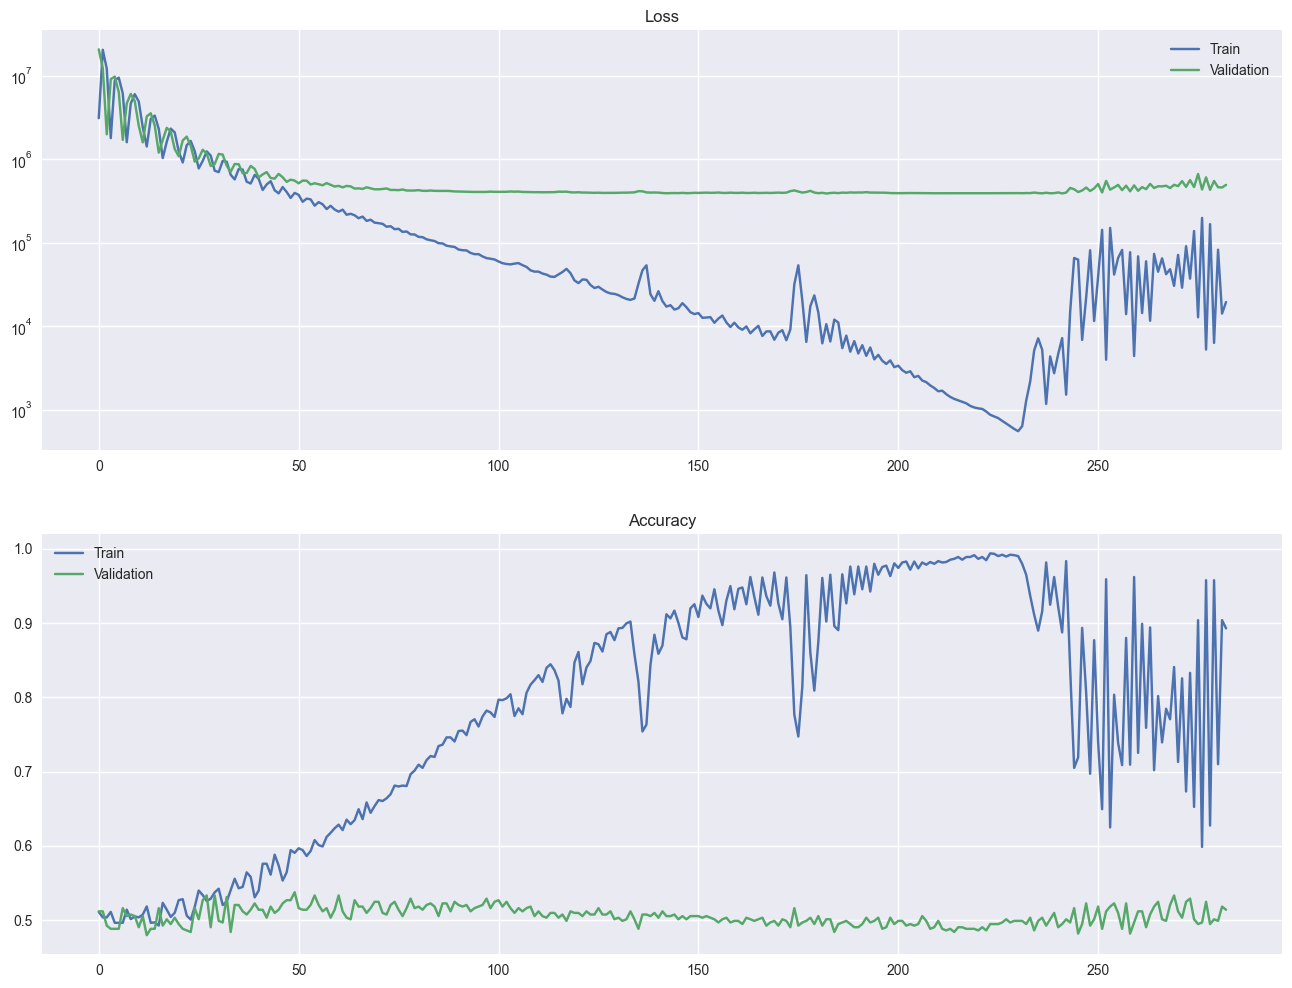

In [11]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

axes[0].set_title("Loss")
axes[0].set_yscale("log")
axes[0].plot(train_history.history["loss"], label="Train")
axes[0].plot(train_history.history["val_loss"], label="Validation")
axes[0].legend()

axes[1].set_title("Accuracy")
axes[1].plot(train_history.history["accuracy"], label="Train")
axes[1].plot(train_history.history["val_accuracy"], label="Validation")
axes[1].legend()

訓練集的loss下降很快，但驗證集的loss停在高位。
且訓練集的準確率接近1，但驗證集的準確率僅0.5，表示模型過擬合